In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os.path


In [2]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

cuda


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.5, 0.5, 0.5),
        (0.5, 0.5, 0.5)
    )
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


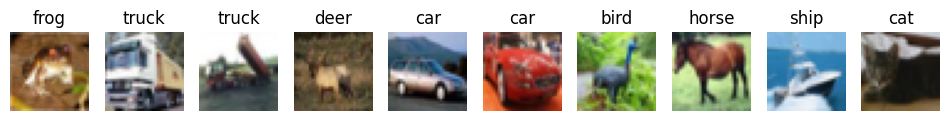

In [4]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()


In [5]:
class ConvNeuralNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2, stride=2)

        self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x

net = ConvNeuralNet()
net.to(device)
PATH = './cifar_net.pth'


# for name, param in net.named_parameters():
#     if "conv" in name:
#         param.requires_grad = False


In [6]:
# conv1_output = None

# def hook_fn(module, input, output):
#     global conv1_output
#     conv1_output = output  # Store output of conv1

# hook = net.conv1.register_forward_hook(hook_fn)

In [7]:
if os.path.isfile(PATH):
    net.load_state_dict(torch.load(PATH, weights_only=True))
    print("existing model loaded")
else:
    print("no existing model found. Initiating training\n")
    loss_function = nn.NLLLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    
    epochs = 10
    for epoch in range(epochs):
    
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
    
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
    
            loss.backward()
            optimizer.step()
    
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
    
    print('Finished Training')
    torch.save(net.state_dict(), PATH)

existing model loaded


In [8]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    ax1.imshow(denormalized_image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

tensor([[ -0.6703,  -3.4164,  -4.5106,  -7.5199,  -5.3714,  -6.6545, -12.3579,
          -5.7130,  -0.8658,  -4.2605]], device='cuda:0')


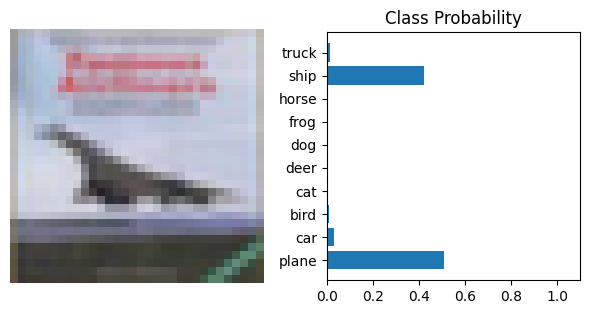

In [43]:
images, _ = next(iter(test_loader))

image = images[3]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)

probabilities = torch.exp(log_probabilities).squeeze().cpu()
view_classification(image, probabilities)

In [48]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)

        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

tensor([[ -4.7637,  -3.6276,  -3.0869,  -0.6901,  -5.2786,  -1.4384,  -4.1774,
          -3.6413,  -3.0623,  -2.4420],
        [-12.7138,  -0.4168, -15.4764, -14.1128, -22.0650, -18.1169, -19.6492,
         -14.2395,  -1.0878,  -5.5474],
        [ -2.7257,  -2.1383,  -4.2183,  -4.1390,  -4.3326,  -5.4971,  -5.9520,
          -4.2886,  -0.5399,  -1.7743],
        [ -0.6703,  -3.4164,  -4.5106,  -7.5199,  -5.3714,  -6.6545, -12.3579,
          -5.7130,  -0.8658,  -4.2605]], device='cuda:0')
tensor([[-11.7654, -12.3378,  -3.5300,  -1.6522,  -1.0733,  -4.6577,  -0.8500,
          -8.6280,  -9.1731, -12.6385],
        [-11.8731, -12.6313,  -3.8392,  -1.0394,  -5.0691,  -2.1544,  -0.6888,
          -8.1675,  -9.4148, -10.4093],
        [ -2.8229,  -5.1562,  -3.3041,  -0.8144,  -3.7791,  -0.9266,  -6.0538,
          -3.8081,  -5.5622,  -4.8213],
        [ -6.2171,  -9.3204,  -1.0254,  -1.7727,  -1.4817,  -3.4697,  -1.6190,
          -5.2693,  -4.9612,  -7.1871]], device='cuda:0')
tensor([[-1.

In [24]:
# Freeze all the parameters in the network
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [50]:
# iterable_of_tensors = [train_loader.dataset[0][0][i] for i in range(train_loader.dataset[0][0].size(0))]
# for t in iterable_of_tenosrs:
#     t = t.requires_grad_(True)
img = train_loader.dataset[0][0]
img = img.to(device)
img = img.requires_grad_(True)
iterable_of_tensors = [img[i].detach().clone().requires_grad_(True) for i in range(img.size(0))]

label = torch.tensor([1]).to(device)

input_img = torch.stack(iterable_of_tensors)

# print(f"model parameter values before gradient descent propagation\n")
# for idx, param in enumerate(iterable_of_tensors):
#     print(f"{param.data}\n")

for _ in range(10):

    # loss_function = nn.NLLLoss()
    loss_function = nn.CrossEntropyLoss()
    loss_function2 = nn.L1Loss()
    
    optim = torch.optim.SGD(iterable_of_tensors, lr=1e-2, momentum=0.9)
    
    optim.zero_grad()
    
    output = net(input_img.unsqueeze(0))

    print(probabilities)
    celoss = loss_function(output, label)
    l1loss = loss_function2(output, label)
    loss = celoss + l1loss
    
    loss.backward()
    optim.step()

    with torch.no_grad():
        log_probabilities = net()
    
    probabilities = torch.exp(log_probabilities).squeeze().cpu()

# print(f"model parameter values after gradient descent propagation\n")
# for idx, param in enumerate(iterable_of_tensors):
#     print(f"{param.data}\n")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x36 and 4608x120)

tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0.

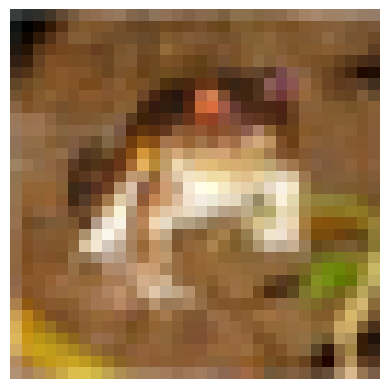

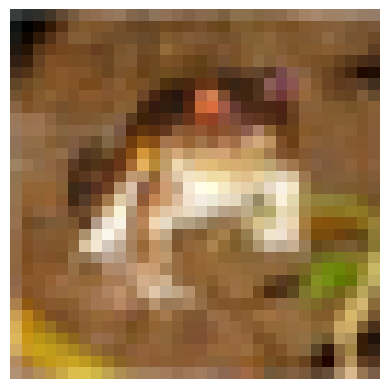

In [52]:
'''
reverse iterable tensors
'''

image = train_loader.dataset[0][0].permute(1, 2, 0)
denormalized_image= image / 2 + 0.5

reconstructed_img = torch.stack(iterable_of_tensors, dim = 0)

mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(3, 1, 1)
reconstructed_img = reconstructed_img / 2 + 0.5  # Reverse normalization

print(reconstructed_img)
# output = net(reconstructed_img)
# print(output)

# Clip to valid range [0, 1] (for visualization)
reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

# Convert to NumPy and permute dimensions for matplotlib (H × W × C)
img_np = reconstructed_img.detach().cpu().numpy().transpose(1, 2, 0)

# Visualize
plt.imshow(denormalized_image)
plt.axis('off')  # Hide axes
plt.show()

# Visualize
plt.imshow(img_np)
plt.axis('off')  # Hide axes
plt.show()